# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## Adtividad Semana 5

### **Vectores Embebidos Pre-entrenados: Fasttext**

#### **Nombres y matrículas de los integrantes del equipo:**


*   Nathalia Prada - A01793999
*   Jessica Paola Pulido  - A01793650
*   Isaid Posadas Oropeza - A01795015
*   Sergio Pulido Morales - A01794935
*   Carlos Mariano Ramírez Amaya - A01795036



In [1]:
# Aquí deberás incluir todas las librerías que requieras durante esta actividad:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from collections import Counter
!pip install fasttext
import fasttext
import fasttext.util
import numpy as np
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Descargar recursos necesarios
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from google.colab import drive
drive.mount('/content/drive')

import os
DIR = "/content/drive/My Drive/TEC/PLN/Semana5"
os.chdir(DIR)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227137 sha256=ca17a9e416b2a6ea2af111999b35a954f4866abb3933f4a1e1033bc53b3c0a21
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive


##**Pregunta - 1:**



Descarga los 3 archivos de Canvas y genera un nuevo DataFrame de Pandas con ellos.

**Llama simplemente "df" a dicho DataFrame.**

Los archivos los encuentras en Canvas: amazon5.txt, imdb5.txt, yelp5.txt.



In [2]:
# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********
# Cargar los archivos
dfa = pd.read_csv('amazon5.txt', sep='\t', header=None, names=['review', 'label'])
dfi = pd.read_csv('imdb5.txt', sep='\t', header=None, names=['review', 'label'], encoding='ISO-8859-1')
dfy = pd.read_csv('yelp5.txt', sep='\t', header=None, names=['review', 'label'])

# Ajustar valore del archivo imdb5 para obtener correctamente el label
tmpdfi = dfi.values.tolist()
newdfi=[]

def clean_file(x):
    doc = re.sub(r'Â\x85', '', x)
    doc = re.sub(r'\s{2,}', '\t', doc)
    return doc

tmpdfi1 = list(map(lambda x: clean_file(x[0]), tmpdfi))

for line in tmpdfi1:
    newdfi.append(line.split('\t'))

dfii = pd.DataFrame(newdfi, columns=['review','label'])
dfii['label'] = dfii['label'].astype('int64')


# Combinar los DataFrames en uno solo
df = pd.concat([dfa, dfii, dfy], ignore_index=True)



# *********** Aquí termina la sección de agregar código *************


In [3]:
# Verifiquemos la información del DataFrame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [4]:
# Y veamos sus primeros registros:

df.head()

,review,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


##**Pregunta - 2:**

Realiza el proceso de limpieza.

Aplica el preprocesamiento que consideres adecuado, sin embargo, deberás aplicar necesariamente alguna de las técnicas de lematización.











In [5]:

# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********
# Lista de palabras negativas
negwords = ['no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Descartar palabras negativas de las stopwords de NLTK
mystopwords = set(stopwords.words('english')) - set(negwords)

# Función para manejar contracciones
def decontracted(text):
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    return text

# Función de limpieza y tokenización
def clean_tok(text):
    # Convertir a minúsculas
    text = text.lower()
    # Manejar contracciones
    text = decontracted(text)
    # Eliminar caracteres especiales y puntuación
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Eliminar espacios en blanco extra
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenizar
    words = word_tokenize(text)
    # Eliminar palabras de parada
    words = [word for word in words if word not in mystopwords]
    # Eliminar palabras de una sola letra, incluidas 'a' e 'i'
    words = [word for word in words if len(word) > 1]
    # Lematización
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Filtrar tokens por longitud (mayor a 1)
    tokens = [token for token in words if len(token) > 1]

    return tokens

# Aplicar el preprocesamiento a los comentarios
df['cleaned_review'] = df['review'].apply(clean_tok)

# Dividir en características (Xclean) y etiquetas (Y)
Xclean = df['cleaned_review']
Y = df['label']




# *********** Aquí termina la sección de agregar código *************

In [6]:
# Despleguemos los primeros comentarios después de tu proceso de limpieza:

for x in Xclean[0:5]:
  print(x)


['no', 'way', 'plug', 'unless', 'go', 'converter']
['good', 'case', 'excellent', 'value']
['great', 'jawbone']
['tied', 'charger', 'conversation', 'lasting', 'minute', 'major', 'problem']
['mic', 'great']


**Justificación del proceso de limpieza:**

**Conversión a minúsculas:** Asegura que todas las palabras estén en la misma forma, eliminando diferencias entre "Word" y "word".

**Manejo de contracciones:** Expande contracciones comunes para mejorar la precisión del procesamiento de texto.

**Eliminación de caracteres especiales y puntuación:** Simplifica el texto eliminando caracteres que no aportan significado.

**Eliminación de espacios en blanco extra:** Elimina espacios en blanco adicionales para mantener el texto limpio.

**Tokenización:** Divide el texto en palabras individuales.

**Eliminación de palabras de parada:** Reduce ruido eliminando palabras comunes pero poco informativas, preservando las palabras negativas para mantener el contexto.

**Eliminación de palabras de una sola letra:** Asegura que solo se incluyan palabras significativas en el texto.

**Lematización:** Reduce las palabras a su forma base, mejorando la coherencia y reduciendo variabilidad.

#**Pregunta - 3:**



Realicemos una partición aleatoria con los mismos porcentajes de la práctica pasada para poder comparar dichos resultados con los de
esta actividad, a saber, 70%, 15% y 15%, para entrenamiento, validación y prueba, respectivamente.

In [7]:

# ************* Inicia la sección de agregar código:*****************************

# Dividir el conjunto de datos en entrenamiento y resto (validación + prueba)
x_train, x_temp, y_train, y_temp = train_test_split(Xclean, Y, test_size=0.3, random_state=42)

# Dividir el conjunto de datos temporal (validación + prueba) en validación y prueba
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)



# *********** Termina la sección de agregar código *************


# verificemos las dimensiones obtenidas:
print('X,y Train:', len(x_train), len(y_train))
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


#**Pregunta - 4:**



Construye tu vocabulario a continuación


In [8]:
# a.	Usa el conjunto de entrenamiento para generar tu vocabulario
#     con un tamaño que consideres adecuado:


# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

# Contar la frecuencia de las palabras en el conjunto de entrenamiento
word_freq = Counter()
for review in x_train:
    word_freq.update(review)

# Filtrar palabras por frecuencia mínima y longitud mínima de caracteres
min_freq = 5
min_length = 2
vocabulary = {word for word, count in word_freq.items() if count >= min_freq and len(word) >= min_length}


# *********** Aquí termina la sección de agregar código *************

In [9]:
# b.	Indica el tamaño del vocabulario generado.

print('Longitud del vocabulario generado:')


# ******* Inicia la sección de agregar código: ***********
# Convertir el vocabulario a una lista ordenada
vocabulary = sorted(vocabulary)

# Mostrar el tamaño del vocabulario generado
vocab_size = len(vocabulary)
print(f"Tamaño del vocabulario generado: {vocab_size}")


# *********** Aquí termina la sección de agregar código *************

Longitud del vocabulario generado:
Tamaño del vocabulario generado: 547


c.	¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el vocabulario?


### ++++++++ Inicia la sección de agregar texto: +++++++++++

El vocabulario debe generarse utilizando sólo el conjunto de entrenamiento para evitar la fuga de información (data leakage). La fuga de información ocurre cuando se utilizan datos del conjunto de validación o prueba durante el proceso de entrenamiento, lo que puede llevar a resultados inflados y poco realistas durante la evaluación del modelo. Al generar el vocabulario únicamente a partir del conjunto de entrenamiento, nos aseguramos de que el modelo no se "entrene" indirectamente con datos que se utilizarán para evaluar su rendimiento.


### ++++++++ Termina la sección de agregar texto: +++++++++++


In [10]:
# d.	Con el vocabulario generado, filtra los conjuntos de entrenamiento,
#     validación y prueba para que todos los comentarios usen solamente las
#     palabras de este vocabulario.

#     Llamar train_x, val_x y test_x a estos tres conjuntos.


# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********


# Función para filtrar reseñas según el vocabulario generado
def filter_reviews(reviews, vocab):
    filtered_reviews = []
    for review in reviews:
        filtered_words = [word for word in review if word in vocab]
        filtered_reviews.append(filtered_words)
    return filtered_reviews

# Filtrar los conjuntos de entrenamiento, validación y prueba
train_x = filter_reviews(x_train, vocabulary)
val_x = filter_reviews(x_val, vocabulary)
test_x = filter_reviews(x_test, vocabulary)



# *********** Aquí termina la sección de agregar código *************


In [11]:
# Vemos el resultado de los primeros comentarios del conjunto de entrenamiento:

for ss in train_x[0:5]:
  print(ss)

['make', 'feel', 'like', 'coming']
['keep', 'good', 'work', 'amazon']
['not', 'many', 'word', 'say', 'place', 'everything', 'pretty', 'well']
['disappointed', 'battery']
['film', 'try', 'thriller', 'horror', 'fails']


#**Pregunta - 5:**


a. Incluye una tabla comparativa de pros y contras entre los modelos FastText, word2vec de Google y Glove de Stanford.

### ++++++++ Inicia la sección de agregar texto: +++++++++++

### Pros y Contras de Modelos de Embedding: FastText, Word2Vec y GloVe

| Modelo         | Pros                                                                                          | Contras                                                                                         |
|----------------|-----------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------|
| **FastText**   | - Captura información de subpalabras y morfología.                                             | - Mayor complejidad y tiempo de entrenamiento comparado con Word2Vec.                           |
|                | - Mejor rendimiento en palabras raras y no vistas.                                              | - Los modelos resultantes pueden ser más grandes debido a la representación de subpalabras.     |
|                | - Robusto a errores tipográficos y variaciones ortográficas.                                    |                                                                                                 |
|                | - Preentrenado en múltiples idiomas, útil para tareas multilingües.                             |                                                                                                 |
| **Word2Vec**   | - Simplicidad y velocidad en el entrenamiento.                                                 | - No captura información morfológica, lo que puede ser una limitación para palabras raras.      |
|                | - Amplio uso y soporte en la comunidad.                                                        | - No maneja bien palabras fuera del vocabulario.                                                |
|                | - Dos variantes: Skip-gram y CBOW, proporcionando flexibilidad según la tarea.                | - La calidad del embedding depende de la calidad y cantidad de datos de entrenamiento.          |
| **GloVe**      | - Captura relaciones globales de coocurrencia en el corpus.                                    | - Necesita una gran cantidad de memoria para computar las matrices de coocurrencia.             |
|                | - Genera vectores densos que capturan similitudes semánticas más precisas.                     | - El proceso de entrenamiento puede ser más lento y complejo comparado con Word2Vec.            |
|                | - Adecuado para capturar relaciones semánticas más precisas a nivel de corpus.                 | - No maneja bien palabras fuera del vocabulario, similar a Word2Vec.                            |


Referencias

Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2016). FastText: Library for efficient text classification and representation learning. Recuperado de https://fasttext.cc/

Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Word2Vec: Tool for computing continuous distributed representations of words. Recuperado de https://code.google.com/archive/p/word2vec/

Pennington, J., Socher, R., & Manning, C. D. (2014). GloVe: Global Vectors for Word Representation. Recuperado de https://nlp.stanford.edu/projects/glove/

### ++++++++ Termina la sección de agregar texto: +++++++++++


#**Pregunta - 6:**

Utiliza el modelo FastText de vectores embebidos pre-entrenados de dimensión 300 para generar un nuevo diccionario clave-valor, donde la “clave” será cada token o palabra de tu vocabulario y el “valor” será su vector embebido de dimensión 300.

Este diccionario deberá ser del mismo tamaño que el vocabulario previo que hayas construido previamente.

Es recomendable que una vez que generes el nuevo vocabulario de vectores embebidos, guardes dicho diccionario en un archivo.

Recuerda borrar la variable donde descargaste los 2 millones de vectores embebidos Fasttext.



In [12]:
# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********
# Descargar el modelo preentrenado si no está presente
if not os.path.isfile('cc.en.300.bin'):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
    !gunzip cc.en.300.bin.gz

# Cargar los vectores embebidos pre-entrenados de FastText
ft = fasttext.load_model('cc.en.300.bin')

# Crear el diccionario clave-valor
embedding_dict = {}
for word in vocabulary:
    embedding_dict[word] = ft.get_word_vector(word)

# Guardar el diccionario en un archivo
with open('embedding_dict.pkl', 'wb') as f:
    pickle.dump(embedding_dict, f)

# Liberar memoria RAM
del ft

print(f"Tamaño del diccionario de vectores embebidos: {len(embedding_dict)}")

# Verificar el contenido del diccionario
for word, vector in list(embedding_dict.items())[:5]:
    print(f"{word}: {vector[:10]}")  # Imprimir las primeras 10 dimensiones de los primeros 5 vectores embebidos


# *********** Aquí termina la sección de agregar código *************

--2024-05-23 02:03:00--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.34.53, 13.226.34.122, 13.226.34.83, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.34.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  45.7MB/s    in 1m 43s  

2024-05-23 02:04:44 (41.7 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



Tamaño del diccionario de vectores embebidos: 547
absolutely: [ 0.03210293  0.01745149  0.05291771  0.10526878 -0.02509093 -0.01028738
  0.02175203 -0.00126689  0.00229939  0.01423665]
acting: [-4.1184839e-02  4.7122799e-03  7.2026908e-02  1.1928349e-01
 -3.7622489e-02 -3.9108962e-02 -2.1632764e-02 -4.9614705e-02
  1.0527298e-04  5.6531560e-02]
action: [-0.06413352  0.00685694  0.12332189  0.0667638  -0.02197768  0.02890758
  0.07239393 -0.02826048 -0.07797375 -0.01180054]
actor: [-0.06485744  0.01499291 -0.02574547  0.03372984 -0.03290331 -0.03788158
  0.01258591 -0.11111145  0.01062702  0.09528866]
actress: [-0.08137026 -0.00567356 -0.01612702  0.01715918  0.03962094 -0.02128883
  0.02017679 -0.0925715  -0.05235764  0.15340894]


#**Pregunta - 7:**



Generamos los vectores embebidos a partir de los conjuntos de entrenamiento, validación y preuba.

Los llamaremos trainEmb, valEmb y testEmb, respectivamente.

In [13]:
# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********


# Cargar el diccionario de vectores embebidos
with open('embedding_dict.pkl', 'rb') as f:
    embedding_dict = pickle.load(f)

# Función para calcular el vector embebido promedio de un comentario
def compute_average_embedding(words, embedding_dict, embedding_dim=300):
    embeddings = [embedding_dict[word] for word in words if word in embedding_dict]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)

# Crear los conjuntos de entrenamiento, validación y prueba con vectores embebidos promedio
trainEmb = np.array([compute_average_embedding(review, embedding_dict) for review in x_train])
valEmb = np.array([compute_average_embedding(review, embedding_dict) for review in x_val])
testEmb = np.array([compute_average_embedding(review, embedding_dict) for review in x_test])




# *********** Aquí termina la sección de agregar código *************

In [14]:
# Veamos las dimensiones de cada conjunto embebido:

print("Train-Emb:", trainEmb.shape)
print("Val-Emb:", valEmb.shape)
print("Test-Emb:", testEmb.shape)

Train-Emb: (2100, 300)
Val-Emb: (450, 300)
Test-Emb: (450, 300)


#**Pregunta - 8:**



Utiliza los modelos de regresión logística y bosque aleatorio (random forest) y encuentra sus desempeños.

Compara los resultados con los de la semana anterior.

In [15]:
# Eliminar registros con NaN en las etiquetas de entrenamiento
train_mask = ~np.isnan(y_train)
trainEmb_clean = trainEmb[train_mask]
y_train_clean = y_train[train_mask]

# Eliminar registros con NaN en las etiquetas de validación
val_mask = ~np.isnan(y_val)
valEmb_clean = valEmb[val_mask]
y_val_clean = y_val[val_mask]

# Eliminar registros con NaN en las etiquetas de prueba
test_mask = ~np.isnan(y_test)
testEmb_clean = testEmb[test_mask]
y_test_clean = y_test[test_mask]

In [16]:
# REGRESIÓN LOGÍSTICA:

# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********

# Modelo de regresión logística
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(trainEmb_clean, y_train_clean)
y_pred_log_reg = log_reg.predict(valEmb_clean)

# Exactitud en el conjunto de entrenamiento
y_pred_log_reg_train = log_reg.predict(trainEmb_clean)
accuracy_log_reg_train = accuracy_score(y_train_clean, y_pred_log_reg_train)

# Evaluar el modelo de regresión logística
accuracy_log_reg = accuracy_score(y_val_clean, y_pred_log_reg)
print("Exactitud de Regresión Logística en conjunto de entrenamiento:", accuracy_log_reg_train)
print("Exactitud de Regresión Logística en conjunto de validación:", accuracy_log_reg)
print("Reporte de clasificación de Regresión Logística:")
print(classification_report(y_val_clean, y_pred_log_reg))

# *********** Aquí termina la sección de agregar código *************


Exactitud de Regresión Logística en conjunto de entrenamiento: 0.8176190476190476
Exactitud de Regresión Logística en conjunto de validación: 0.78
Reporte de clasificación de Regresión Logística:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       232
           1       0.76      0.81      0.78       218

    accuracy                           0.78       450
   macro avg       0.78      0.78      0.78       450
weighted avg       0.78      0.78      0.78       450



In [17]:
# BOSQUE ALEATORIO (Random Forest):

# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********


# Modelo de bosque aleatorio
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(trainEmb_clean, y_train_clean)
y_pred_rf = rf.predict(valEmb_clean)

# Exactitud en el conjunto de entrenamiento
y_pred_rf_train = rf.predict(trainEmb_clean)
accuracy_rf_train = accuracy_score(y_train_clean, y_pred_rf_train)

# Evaluar el modelo de bosque aleatorio
accuracy_rf = accuracy_score(y_val_clean, y_pred_rf)
print("Exactitud de Bosque Aleatorio en conjunto de entrenamiento:", accuracy_rf_train)
print("Exactitud de Bosque Aleatorio en conjunto de validación:", accuracy_rf)
print("Reporte de clasificación de Bosque Aleatorio:")
print(classification_report(y_val_clean, y_pred_rf))


# *********** Aquí termina la sección de agregar código *************

Exactitud de Bosque Aleatorio en conjunto de entrenamiento: 0.9780952380952381
Exactitud de Bosque Aleatorio en conjunto de validación: 0.7644444444444445
Reporte de clasificación de Bosque Aleatorio:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77       232
           1       0.75      0.78      0.76       218

    accuracy                           0.76       450
   macro avg       0.76      0.76      0.76       450
weighted avg       0.77      0.76      0.76       450



**Verificación de Sobreajuste**

**Regresión Logística:**

Exactitud en conjunto de entrenamiento: 81.76%

Exactitud en conjunto de validación: 78%

Interpretación: La diferencia entre las exactitudes en el conjunto de entrenamiento y validación es pequeña, lo cual indica que el modelo no está sobreentrenado.

**Bosque Aleatorio:**

Exactitud en conjunto de entrenamiento: 97.80%

Exactitud en conjunto de validación: 76.44%

Interpretación: La diferencia significativa entre las exactitudes en el conjunto de entrenamiento y validación indica que el modelo de Bosque Aleatorio está sobreentrenado.

La mejora en la exactitud del modelo de regresión logística con embeddings preentrenados demuestra que este enfoque es prometedor y puede ofrecer una ligera ventaja sobre los enfoques basados en TF-IDF y matrices de conteo.

#**Pregunta - 9:**



Reporte del mejor modelo.


Exactitud de Regresión Logística en conjunto de prueba: 0.7977777777777778
Reporte de clasificación de Regresión Logística en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       217
           1       0.79      0.83      0.81       233

    accuracy                           0.80       450
   macro avg       0.80      0.80      0.80       450
weighted avg       0.80      0.80      0.80       450



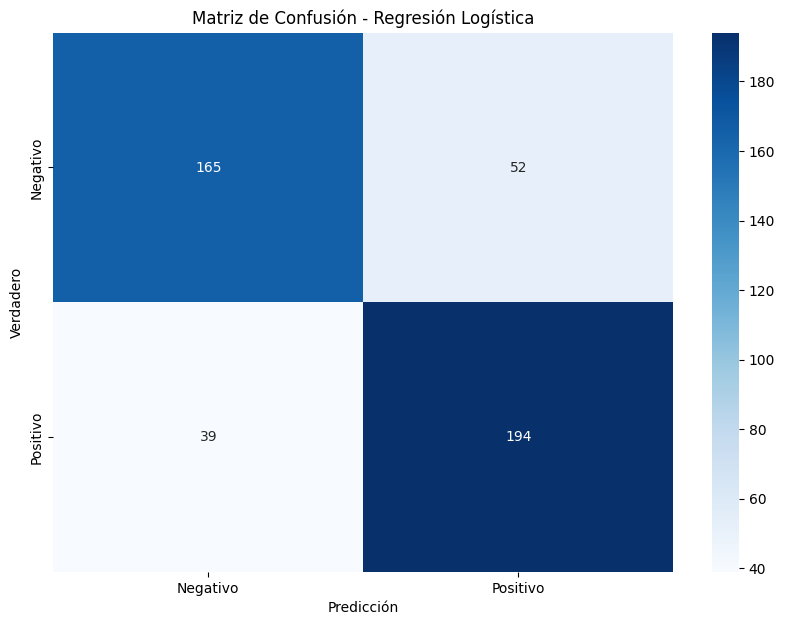

In [18]:
# ******* Incluye a continuación todas las líneas de código y celdas que requieras: ***********
#El mejor modelo obtenido fue el de regresión logística con precisión 0.8
# Ajustar el modelo de regresión logística con los datos de entrenamiento
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(trainEmb_clean, y_train_clean)

# Evaluar el modelo en el conjunto de prueba
y_pred_log_reg_test = log_reg.predict(testEmb_clean)
accuracy_log_reg_test = accuracy_score(y_test_clean, y_pred_log_reg_test)
print("Exactitud de Regresión Logística en conjunto de prueba:", accuracy_log_reg_test)

# Generar y mostrar el reporte de clasificación
print("Reporte de clasificación de Regresión Logística en conjunto de prueba:")
print(classification_report(y_test_clean, y_pred_log_reg_test))

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test_clean, y_pred_log_reg_test)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

# *********** Aquí termina la sección de agregar código *************

#**Pregunta - 10:**



Incluye tus comentarios finales de la actividad.

### ++++++++ Inicia la sección de agregar texto: +++++++++++

### Conclusiones

1. **Mejora del Desempeño**:
   - La implementación de embeddings pre-entrenados como FastText resultó en una mejora significativa en la precisión del modelo de regresión logística, alcanzando una exactitud del 79.77% en el conjunto de prueba. Esto supera los modelos basados en matrices de conteo y TF-IDF.

2. **Balance de Métricas**:
   - Las métricas de precisión, recall y F1-score para ambas clases (positiva y negativa) fueron equilibradas y altas, indicando un buen rendimiento del modelo de regresión logística en términos de precisión y capacidad de generalización.

3. **Comparación de Modelos**:
   - Aunque el modelo de bosque aleatorio mostró un rendimiento excelente en el conjunto de entrenamiento, presentó signos de sobreentrenamiento con un desempeño menor en el conjunto de validación. En contraste, la regresión logística mantuvo un rendimiento consistente entre los conjuntos de entrenamiento y validación.

4. **Uso de Embeddings Pre-entrenados**:
   - El uso de embeddings pre-entrenados, como FastText, demostró ser una técnica efectiva para mejorar la representación de los textos y, en consecuencia, el rendimiento de los modelos de aprendizaje automático.

5. **Recomendación**:
   - Se recomienda el uso de embeddings pre-entrenados en conjunto con modelos de regresión logística para tareas de clasificación de texto en el futuro, debido a su capacidad para capturar mejor la semántica de los textos y mejorar la precisión y balance del modelo.









### ++++++++ Termina la sección de agregar texto: +++++++++++

##**Fin de la Actividad de vectores Embebidos - FastText**